# MoA Modeling

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns
 
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed everything, make sure using the same seed is exactly no difference for everything
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic=True
        torch.backends.cudnn.benchmark=False
        
seed_everything(42)

Get data ready

In [3]:
data_dir = '../input/lish-moa/'
os.listdir(data_dir)

train_features = pd.read_csv(data_dir + 'train_features.csv')
train_targets_scored = pd.read_csv(data_dir + 'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(data_dir + 'train_targets_nonscored.csv')
train_drug = pd.read_csv(data_dir + 'train_drug.csv')
test_features = pd.read_csv(data_dir + 'test_features.csv')
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

train_features2=train_features.copy()
test_features2=test_features.copy()

GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

qt = QuantileTransformer(n_quantiles=100,random_state=42,output_distribution='normal')
data = pd.concat([pd.DataFrame(train_features[GENES+CELLS]), pd.DataFrame(test_features[GENES+CELLS])])
data2 = qt.fit_transform(data[GENES+CELLS])
train_features[GENES+CELLS] = pd.DataFrame(data2[:train_features.shape[0]])
test_features[GENES+CELLS] = pd.DataFrame(data2[-test_features.shape[0]:])

n_comp = 600  #<--Update
data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; 
test2 = data2[-test_features.shape[0]:]
train_gpca = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test_gpca = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])
# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train_gpca), axis=1)
test_features = pd.concat((test_features, test_gpca), axis=1)

n_comp = 50  #<--Update
data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]
train_cpca = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cpca = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])
# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train_cpca), axis=1)
test_features = pd.concat((test_features, test_cpca), axis=1)

from sklearn.feature_selection import VarianceThreshold
var_thresh = VarianceThreshold(0.85)  #<-- Update
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])
train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]
train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])
train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)
test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])
test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

from sklearn.cluster import KMeans
def fe_cluster(train, test, n_clusters_g = 22, n_clusters_c = 4, SEED = 42):
    
    features_g = GENES
    features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features2 ,test_features2=fe_cluster(train_features2,test_features2)


train_pca=pd.concat((train_gpca,train_cpca),axis=1)
test_pca=pd.concat((test_gpca,test_cpca),axis=1)

def fe_cluster_pca(train, test,n_clusters=5,SEED = 42):
        data=pd.concat([train,test],axis=0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_pca'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_pca'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_pca'])
        test = pd.get_dummies(test, columns = [f'clusters_pca'])
        return train, test
train_cluster_pca ,test_cluster_pca = fe_cluster_pca(train_pca,test_pca)

train_cluster_pca = train_cluster_pca.iloc[:,650:]
test_cluster_pca = test_cluster_pca.iloc[:,650:]
train_features_cluster=train_features2.iloc[:,876:]
test_features_cluster=test_features2.iloc[:,876:]

gsquarecols=['g-574','g-211','g-216','g-0','g-255','g-577','g-153','g-389','g-60','g-370','g-248','g-167','g-203','g-177','g-301','g-332','g-517','g-6','g-744','g-224','g-162','g-3','g-736','g-486','g-283','g-22','g-359','g-361','g-440','g-335','g-106','g-307','g-745','g-146','g-416','g-298','g-666','g-91','g-17','g-549','g-145','g-157','g-768','g-568','g-396']

def fe_stats(train, test):
    
    features_g = GENES
    features_c = CELLS
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-23'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in gsquarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_features2,test_features2=fe_stats(train_features2,test_features2)


train_features_stats=train_features2.iloc[:,902:]
test_features_stats=test_features2.iloc[:,902:]


train_features = pd.concat((train_features, train_features_cluster,train_cluster_pca,train_features_stats), axis=1)
test_features = pd.concat((test_features, test_features_cluster,test_cluster_pca,test_features_stats), axis=1)


train = train_features.merge(train_targets_scored, on='sig_id')
train = train.merge(train_targets_nonscored, on='sig_id')
train = train.merge(train_drug, on='sig_id')
train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

target_cols = [x for x in train_targets_scored.columns if x != 'sig_id']
aux_target_cols = [x for x in train_targets_nonscored.columns if x != 'sig_id']
all_target_cols = target_cols + aux_target_cols

num_targets = len(target_cols)
num_aux_targets = len(aux_target_cols)
num_all_targets = len(all_target_cols)

print('num_targets: {}'.format(num_targets))
print('num_aux_targets: {}'.format(num_aux_targets))
print('num_all_targets: {}'.format(num_all_targets))

print(train.shape)
print(test.shape)
print(sample_submission.shape)

num_targets: 206
num_aux_targets: 402
num_all_targets: 608
(21948, 1847)
(3624, 1238)
(3982, 207)


## 1. Dataset Classes

In [25]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }

        return dct

In [26]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    return final_loss

def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    return preds

In [27]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# 2. Model 1

In [28]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super(Model, self).__init__()
        self.hidden_size = [1500, 1250, 1000, 750]
        self.dropout_value = [0.5, 0.35, 0.3, 0.25]

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, self.hidden_size[0])
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size[0])
        self.dropout2 = nn.Dropout(self.dropout_value[0])
        self.dense2 = nn.Linear(self.hidden_size[0], self.hidden_size[1])

        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size[1])
        self.dropout3 = nn.Dropout(self.dropout_value[1])
        self.dense3 = nn.Linear(self.hidden_size[1], self.hidden_size[2])

        self.batch_norm4 = nn.BatchNorm1d(self.hidden_size[2])
        self.dropout4 = nn.Dropout(self.dropout_value[2])
        self.dense4 = nn.Linear(self.hidden_size[2], self.hidden_size[3])

        self.batch_norm5 = nn.BatchNorm1d(self.hidden_size[3])
        self.dropout5 = nn.Dropout(self.dropout_value[3])
        self.dense5 = nn.utils.weight_norm(nn.Linear(self.hidden_size[3], num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))

        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))

        x = self.batch_norm5(x)
        x = self.dropout5(x)
        x = self.dense5(x)
        return x
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))   

In [29]:
class FineTuneScheduler:
    def __init__(self, epochs):
        self.epochs = epochs
        self.epochs_per_step = 0
        self.frozen_layers = []

    def copy_without_top(self, model, num_features, num_targets, num_targets_new):
        self.frozen_layers = []

        model_new = Model(num_features, num_targets)
        model_new.load_state_dict(model.state_dict())

        # Freeze all weights
        for name, param in model_new.named_parameters():
            layer_index = name.split('.')[0][-1]

            if layer_index == 5:
                continue

            param.requires_grad = False

            # Save frozen layer names
            if layer_index not in self.frozen_layers:
                self.frozen_layers.append(layer_index)

        self.epochs_per_step = self.epochs // len(self.frozen_layers)

        # Replace the top layers with another ones
        model_new.batch_norm5 = nn.BatchNorm1d(model_new.hidden_size[3])
        model_new.dropout5 = nn.Dropout(model_new.dropout_value[3])
        model_new.dense5 = nn.utils.weight_norm(nn.Linear(model_new.hidden_size[-1], num_targets_new))
        model_new.to(DEVICE)
        return model_new

    def step(self, epoch, model):
        if len(self.frozen_layers) == 0:
            return

        if epoch % self.epochs_per_step == 0:
            last_frozen_index = self.frozen_layers[-1]
            
            # Unfreeze parameters of the last frozen layer
            for name, param in model.named_parameters():
                layer_index = name.split('.')[0][-1]

                if layer_index == last_frozen_index:
                    param.requires_grad = True

            del self.frozen_layers[-1]  # Remove the last layer as unfrozen

## 2.1 Preprocessing

In [10]:
def process_data(data):
    data=pd.get_dummies(data,columns=['cp_time','cp_dose'])    # one hot encoding for categorical feature
    return data

In [11]:
feature_cols = [c for c in process_data(train).columns if c not in all_target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id', 'drug_id']]
num_features = len(feature_cols)
num_features

1240

In [12]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 24
BATCH_SIZE = 128

WEIGHT_DECAY = {'ALL_TARGETS': 1e-5, 'SCORED_ONLY': 3e-6}
MAX_LR = {'ALL_TARGETS': 1e-2, 'SCORED_ONLY': 3e-3}
DIV_FACTOR = {'ALL_TARGETS': 1e3, 'SCORED_ONLY': 1e2}
PCT_START = 0.1

In [13]:
model=Model(num_features,num_all_targets)
model

Model(
  (batch_norm1): BatchNorm1d(1240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=1240, out_features=1500, bias=True)
  (batch_norm2): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1500, out_features=1250, bias=True)
  (batch_norm3): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.35, inplace=False)
  (dense3): Linear(in_features=1250, out_features=1000, bias=True)
  (batch_norm4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (dense4): Linear(in_features=1000, out_features=750, bias=True)
  (batch_norm5): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout5): Dropout(p=0.25, inplace=False)
  (dense5): Linear(in_features=750, out_features=608, 

## 2.2 Single Fold Training

In [15]:
#pip install iterative-stratification

Note: you may need to restart the kernel to use updated packages.


In [17]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.model_selection import KFold

def make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH):
    vc = train.drug_id.value_counts()
    vc1 = vc.loc[vc <= DRUG_THRESH].index.sort_values()
    vc2 = vc.loc[vc > DRUG_THRESH].index.sort_values()

    for seed_id in range(SEEDS):
        kfold_col = 'kfold_{}'.format(seed_id)
        
        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}
        dct2 = {}

        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.groupby('drug_id')[target_cols].mean().loc[vc1]

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.loc[train.drug_id.isin(vc2)].reset_index(drop=True)

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        train[kfold_col] = train.drug_id.map(dct1)
        train.loc[train[kfold_col].isna(), kfold_col] = train.loc[train[kfold_col].isna(), 'sig_id'].map(dct2)
        train[kfold_col] = train[kfold_col].astype('int8')
        
    return train

SEEDS = 7
NFOLDS = 7
DRUG_THRESH = 18

train = make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH)
train.head()

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,xanthine_oxidase_inhibitor,xiap_inhibitor,drug_id,kfold_0,kfold_1,kfold_2,kfold_3,kfold_4,kfold_5,kfold_6
0,id_000644bb2,24,D1,1.146806,0.902075,-0.418339,-0.961202,-0.254770,-1.021300,-1.369236,...,0,0,b68db1d53,1,3,3,5,0,5,2
1,id_000779bfc,72,D1,0.128824,0.676862,0.274345,0.090495,1.208863,0.688965,0.316734,...,0,0,df89a8e5a,0,3,6,3,3,4,1
2,id_000a6266a,48,D1,0.790372,0.939951,1.428097,-0.121817,-0.002067,1.495091,0.238763,...,0,0,18bb41b2c,5,3,3,1,3,0,4
3,id_0015fd391,48,D1,-0.729866,-0.277163,-0.441200,0.766612,2.347817,-0.862761,-2.308829,...,0,0,8c7f86626,4,3,1,2,4,5,2
4,id_001626bd3,72,D2,-0.444558,-0.481202,0.974729,0.977467,1.468304,-0.874772,-0.372682,...,0,0,7cbed3131,6,5,3,3,2,1,4


In [20]:
#train['kfold_0'].value_counts()

6    3195
3    3161
1    3147
5    3145
4    3137
2    3086
0    3077
Name: kfold_0, dtype: int64

In [30]:
def run_training(fold_id, seed_id):
    seed_everything(seed_id)
    
    train_ = process_data(train)
    test_ = process_data(test)
    
    kfold_col = f'kfold_{seed_id}'
    trn_idx = train_[train_[kfold_col] != fold_id].index
    val_idx = train_[train_[kfold_col] == fold_id].index
    
    train_df = train_[train_[kfold_col] != fold_id].reset_index(drop=True)
    valid_df = train_[train_[kfold_col] == fold_id].reset_index(drop=True)
    
    def train_model(model, tag_name, target_cols_now, fine_tune_scheduler=None):
        x_train, y_train  = train_df[feature_cols].values, train_df[target_cols_now].values
        x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols_now].values
        
        train_dataset = MoADataset(x_train, y_train)
        valid_dataset = MoADataset(x_valid, y_valid)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY[tag_name])
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                  steps_per_epoch=len(trainloader),
                                                  pct_start=PCT_START,
                                                  div_factor=DIV_FACTOR[tag_name], 
                                                  max_lr=MAX_LR[tag_name],
                                                  epochs=EPOCHS)
        
        loss_fn = nn.BCEWithLogitsLoss()
        loss_tr = SmoothBCEwLogits(smoothing=0.001)

        oof = np.zeros((len(train), len(target_cols_now)))
        best_loss = np.inf
        
        for epoch in range(EPOCHS):
            if fine_tune_scheduler is not None:
                fine_tune_scheduler.step(epoch, model)

            train_loss = train_fn(model, optimizer, scheduler, loss_tr, trainloader, DEVICE)
            valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
            print(f"SEED: {seed_id}, FOLD: {fold_id}, {tag_name}, EPOCH: {epoch}, train_loss: {train_loss:.6f}, valid_loss: {valid_loss:.6f}")

            if np.isnan(valid_loss):
                break
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                oof[val_idx] = valid_preds
                torch.save(model.state_dict(), f"{tag_name}_FOLD{fold_id}_.pth")

        return oof

    fine_tune_scheduler = FineTuneScheduler(EPOCHS)

    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.to(DEVICE)

    # Train on scored + nonscored targets
    train_model(pretrained_model, 'ALL_TARGETS', all_target_cols)

    # Load the pretrained model with the best loss
    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.load_state_dict(torch.load(f"ALL_TARGETS_FOLD{fold_id}_.pth"))
    pretrained_model.to(DEVICE)

    # Copy model without the top layer
    final_model = fine_tune_scheduler.copy_without_top(pretrained_model, num_features, num_all_targets, num_targets)

    # Fine-tune the model on scored targets only
    oof = train_model(final_model, 'SCORED_ONLY', target_cols, fine_tune_scheduler)

    # Load the fine-tuned model with the best loss
    model = Model(num_features, num_targets)
    model.load_state_dict(torch.load(f"SCORED_ONLY_FOLD{fold_id}_.pth"))
    model.to(DEVICE)

    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    predictions = np.zeros((len(test_), num_targets))
    predictions = inference_fn(model, testloader, DEVICE)
    return oof, predictions

In [31]:
def run_k_fold(NFOLDS, seed_id):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold_id in range(NFOLDS):
        oof_, pred_ = run_training(fold_id, seed_id)
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [32]:
from time import time

# Averaging on multiple SEEDS
SEED = [0, 1, 2, 3, 4, 5, 6]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

time_begin = time()

for seed_id in SEED:
    oof_, predictions_ = run_k_fold(NFOLDS, seed_id)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

time_diff = time() - time_begin

train[target_cols] = oof
test[target_cols] = predictions

SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 0, train_loss: 0.495560, valid_loss: 0.019798
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 1, train_loss: 0.015879, valid_loss: 0.009736
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 2, train_loss: 0.013642, valid_loss: 0.014794
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 3, train_loss: 0.013586, valid_loss: 0.009794
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 4, train_loss: 0.012885, valid_loss: 0.009019
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 5, train_loss: 0.013019, valid_loss: 0.009017
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 6, train_loss: 0.012931, valid_loss: 0.009215
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 7, train_loss: 0.012883, valid_loss: 0.009112
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 8, train_loss: 0.012896, valid_loss: 0.009173
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 9, train_loss: 0.012871, valid_loss: 0.009159
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 10, train_loss: 0.012857, valid_loss: 0.009057
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 11, train_loss: 0.012866, valid_loss:

In [33]:
from datetime import timedelta
str(timedelta(seconds=time_diff))

'1:10:40.196608'

In [36]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
len(target_cols)

206

In [162]:
model

Model(
  (batch_norm1): BatchNorm1d(1240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=1240, out_features=1500, bias=True)
  (batch_norm2): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1500, out_features=1250, bias=True)
  (batch_norm3): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.35, inplace=False)
  (dense3): Linear(in_features=1250, out_features=1000, bias=True)
  (batch_norm4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (dense4): Linear(in_features=1000, out_features=750, bias=True)
  (batch_norm5): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout5): Dropout(p=0.25, inplace=False)
  (dense5): Linear(in_features=750, out_features=206, 

In [163]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0

for i in range(len(target_cols)):
    score += log_loss(y_true[:, i], y_pred[:, i])

print("CV log_loss: ", score / y_pred.shape[1])

CV log_loss:  0.015617073184891955


In [167]:
sub1 = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

# Model 2

In [168]:
import sys
sys.path.insert(0, "../input/tabnetdevelop/tabnet-develop")

In [169]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import RobustScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
from sklearn.preprocessing import QuantileTransformer
import random
import sys
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from tqdm import tqdm
from sklearn.metrics import log_loss

In [170]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]
for col in (GENES + CELLS):

    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
    
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)



from sklearn.decomposition import PCA
n_comp = 600  #<--Update

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)



n_comp = 50  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

from sklearn.feature_selection import VarianceThreshold


var_thresh = VarianceThreshold(0.8)  #<-- Update
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features.shape

(23814, 1040)

In [171]:
def get_ratio_labels(df):
    columns = list(df.columns)
    columns.pop(0)
    ratios = []
    toremove = []
    for c in columns:
        counts = df[c].value_counts()
        if len(counts) != 1:
            ratios.append(counts[0]/counts[1])
        else:
            toremove.append(c)
    print(f"remove {len(toremove)} columns")
    
    for t in toremove:
        columns.remove(t)
    return columns, np.array(ratios).astype(np.int32)

columns, ratios = get_ratio_labels(train_targets_scored)
columns_nonscored, ratios_nonscored = get_ratio_labels(train_targets_nonscored)

remove 0 columns
remove 71 columns


In [177]:
remove_vehicle=True
def transform_data(train, test, col, normalize=True, removed_vehicle=False):
    """
        the first 3 columns represents categories, the others numericals features
    """
    mapping = {"cp_type":{"trt_cp": 0, "ctl_vehicle":1},
               "cp_time":{48:0, 72:1, 24:2},
               "cp_dose":{"D1":0, "D2":1}}
    
    if removed_vehicle:
        categories_tr = np.stack([ train[c].apply(lambda x: mapping[c][x]).values for c in col[1:3]], axis=1)
        categories_test = np.stack([ test[c].apply(lambda x: mapping[c][x]).values for c in col[1:3]], axis=1)
    else:
        categories_tr = np.stack([ train[c].apply(lambda x: mapping[c][x]).values for c in col[:3]], axis=1)
        categories_test = np.stack([ test[c].apply(lambda x: mapping[c][x]).values for c in col[:3]], axis=1)
    
    max_ = 10.
    min_ = -10.
   
    if removed_vehicle:
        numerical_tr = train[col[3:]].values
        numerical_test = test[col[3:]].values
    else:
        numerical_tr = train[col[3:]].values
        numerical_test = test[col[3:]].values
    if normalize:
        numerical_tr = (numerical_tr-min_)/(max_ - min_)
        numerical_test = (numerical_test-min_)/(max_ - min_)
    return categories_tr, categories_test, numerical_tr, numerical_test
col_features = list(train_features.columns)[1:]
cat_tr, cat_test, numerical_tr, numerical_test = transform_data(train_features, test_features, col_features, normalize=False, removed_vehicle=remove_vehicle)
targets_tr = train_targets_scored[columns].values.astype(np.float32)
targets2_tr = train_targets_nonscored[columns_nonscored].values.astype(np.float32)

In [178]:
def inference_fn(model, X ,verbose=True):
    with torch.no_grad():
        y_preds = model.predict( X )
        y_preds = torch.sigmoid(torch.as_tensor(y_preds)).numpy()
    return y_preds

In [179]:
def log_loss_score(actual, predicted,  eps=1e-15):

        """
        :param predicted:   The predicted probabilities as floats between 0-1
        :param actual:      The binary labels. Either 0 or 1.
        :param eps:         Log(0) is equal to infinity, so we need to offset our predicted values slightly by eps from 0 or 1
        :return:            The logarithmic loss between between the predicted probability assigned to the possible outcomes for item i, and the actual outcome.
        """

        
        p1 = actual * np.log(predicted+eps)
        p0 = (1-actual) * np.log(1-predicted+eps)
        loss = p0 + p1

        return -loss.mean()

In [180]:
def log_loss_multi(y_true, y_pred):
    M = y_true.shape[1]
    results = np.zeros(M)
    for i in range(M):
        results[i] = log_loss_score(y_true[:,i], y_pred[:,i])
    return results.mean()

In [181]:
def check_targets(targets):
    ### check if targets are all binary in training set
    
    for i in range(targets.shape[1]):
        if len(np.unique(targets[:,i])) != 2:
            return False
    return True

In [182]:
def auc_multi(y_true, y_pred):
    M = y_true.shape[1]
    results = np.zeros(M)
    for i in range(M):
        try:
            results[i] = roc_auc_score(y_true[:,i], y_pred[:,i])
        except:
            pass
    return results.mean()

In [183]:
import torch
import numpy as np
from scipy.sparse import csc_matrix
import time
from abc import abstractmethod
from pytorch_tabnet import tab_network
from pytorch_tabnet.multiclass_utils import unique_labels
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
from torch.nn.utils import clip_grad_norm_
from pytorch_tabnet.utils import (PredictDataset,
                                  create_dataloaders,
                                  create_explain_matrix)
from sklearn.base import BaseEstimator
from torch.utils.data import DataLoader
from copy import deepcopy
import io
import json
from pathlib import Path
import shutil
import zipfile

class TabModel(BaseEstimator):
    def __init__(self, n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1,
                 n_independent=2, n_shared=2, epsilon=1e-15,  momentum=0.02,
                 lambda_sparse=1e-3, seed=0,
                 clip_value=1, verbose=1,
                 optimizer_fn=torch.optim.Adam,
                 optimizer_params=dict(lr=2e-2),
                 scheduler_params=None, scheduler_fn=None,
                 mask_type="sparsemax",
                 input_dim=None, output_dim=None,
                 device_name='auto'):
        """ Class for TabNet model
        Parameters
        ----------
            device_name: str
                'cuda' if running on GPU, 'cpu' if not, 'auto' to autodetect
        """

        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.cat_idxs = cat_idxs
        self.cat_dims = cat_dims
        self.cat_emb_dim = cat_emb_dim
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.epsilon = epsilon
        self.momentum = momentum
        self.lambda_sparse = lambda_sparse
        self.clip_value = clip_value
        self.verbose = verbose
        self.optimizer_fn = optimizer_fn
        self.optimizer_params = optimizer_params
        self.device_name = device_name
        self.scheduler_params = scheduler_params
        self.scheduler_fn = scheduler_fn
        self.mask_type = mask_type
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.batch_size = 1024

        self.seed = seed
        torch.manual_seed(self.seed)
        # Defining device
        if device_name == 'auto':
            if torch.cuda.is_available():
                device_name = 'cuda'
            else:
                device_name = 'cpu'
        self.device = torch.device(device_name)
        print(f"Device used : {self.device}")

    @abstractmethod
    def construct_loaders(self, X_train, y_train, X_valid, y_valid,
                          weights, batch_size, num_workers, drop_last):
        """
        Returns
        -------
        train_dataloader, valid_dataloader : torch.DataLoader, torch.DataLoader
            Training and validation dataloaders
        -------
        """
        raise NotImplementedError('users must define construct_loaders to use this base class')

    def init_network(
                     self,
                     input_dim,
                     output_dim,
                     n_d,
                     n_a,
                     n_steps,
                     gamma,
                     cat_idxs,
                     cat_dims,
                     cat_emb_dim,
                     n_independent,
                     n_shared,
                     epsilon,
                     virtual_batch_size,
                     momentum,
                     device_name,
                     mask_type,
                     ):
        self.network = tab_network.TabNet(
            input_dim,
            output_dim,
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=cat_emb_dim,
            n_independent=n_independent,
            n_shared=n_shared,
            epsilon=epsilon,
            virtual_batch_size=virtual_batch_size,
            momentum=momentum,
            device_name=device_name,
            mask_type=mask_type).to(self.device)

        self.reducing_matrix = create_explain_matrix(
            self.network.input_dim,
            self.network.cat_emb_dim,
            self.network.cat_idxs,
            self.network.post_embed_dim)

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, loss_fn=None,
            weights=0, max_epochs=100, patience=10, batch_size=1024,
            virtual_batch_size=128, num_workers=0, drop_last=False):
        """Train a neural network stored in self.network
        Using train_dataloader for training data and
        valid_dataloader for validation.
        Parameters
        ----------
            X_train: np.ndarray
                Train set
            y_train : np.array
                Train targets
            X_train: np.ndarray
                Train set
            y_train : np.array
                Train targets
            weights : bool or dictionnary
                0 for no balancing
                1 for automated balancing
                dict for custom weights per class
            max_epochs : int
                Maximum number of epochs during training
            patience : int
                Number of consecutive non improving epoch before early stopping
            batch_size : int
                Training batch size
            virtual_batch_size : int
                Batch size for Ghost Batch Normalization (virtual_batch_size < batch_size)
            num_workers : int
                Number of workers used in torch.utils.data.DataLoader
            drop_last : bool
                Whether to drop last batch during training
        """
        # update model name

        self.update_fit_params(X_train, y_train, X_valid, y_valid, loss_fn,
                               weights, max_epochs, patience, batch_size,
                               virtual_batch_size, num_workers, drop_last)

        train_dataloader, valid_dataloader = self.construct_loaders(X_train,
                                                                    y_train,
                                                                    X_valid,
                                                                    y_valid,
                                                                    self.updated_weights,
                                                                    self.batch_size,
                                                                    self.num_workers,
                                                                    self.drop_last)

        self.init_network(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            epsilon=self.epsilon,
            virtual_batch_size=self.virtual_batch_size,
            momentum=self.momentum,
            device_name=self.device_name,
            mask_type=self.mask_type
        )

        self.optimizer = self.optimizer_fn(self.network.parameters(),
                                           **self.optimizer_params)

        if self.scheduler_fn:
            self.scheduler = self.scheduler_fn(self.optimizer, **self.scheduler_params)
        else:
            self.scheduler = None

        self.losses_train = []
        self.losses_valid = []
        self.learning_rates = []
        self.metrics_train = []
        self.metrics_valid = []

        if self.verbose > 0:
            print("Will train until validation stopping metric",
                  f"hasn't improved in {self.patience} rounds.")
            msg_epoch = f'| EPOCH |  train  |   valid  | total time (s)'
            print('---------------------------------------')
            print(msg_epoch)

        total_time = 0
        while (self.epoch < self.max_epochs and
               self.patience_counter < self.patience):
            starting_time = time.time()
            # updates learning rate history
            self.learning_rates.append(self.optimizer.param_groups[-1]["lr"])

            fit_metrics = self.fit_epoch(train_dataloader, valid_dataloader)

            # leaving it here, may be used for callbacks later
            self.losses_train.append(fit_metrics['train']['loss_avg'])
            self.losses_valid.append(fit_metrics['valid']['total_loss'])
            self.metrics_train.append(fit_metrics['train']['stopping_loss'])
            self.metrics_valid.append(fit_metrics['valid']['stopping_loss'])

            stopping_loss = fit_metrics['valid']['stopping_loss']
            if stopping_loss < self.best_cost:
                self.best_cost = stopping_loss
                self.patience_counter = 0
                # Saving model
                self.best_network = deepcopy(self.network)
                has_improved = True
            else:
                self.patience_counter += 1
                has_improved=False
            self.epoch += 1
            total_time += time.time() - starting_time
            if self.verbose > 0:
                if self.epoch % self.verbose == 0:
                    separator = "|"
                    msg_epoch = f"| {self.epoch:<5} | "
                    msg_epoch += f" {fit_metrics['train']['stopping_loss']:.5f}"
                    msg_epoch += f' {separator:<2} '
                    msg_epoch += f" {fit_metrics['valid']['stopping_loss']:.5f}"
                    msg_epoch += f' {separator:<2} '
                    msg_epoch += f" {np.round(total_time, 1):<10}"
                    msg_epoch += f" {has_improved}"
                    print(msg_epoch)

        if self.verbose > 0:
            if self.patience_counter == self.patience:
                print(f"Early stopping occured at epoch {self.epoch}")
            print(f"Training done in {total_time:.3f} seconds.")
            print('---------------------------------------')

        self.history = {"train": {"loss": self.losses_train,
                                  "metric": self.metrics_train,
                                  "lr": self.learning_rates},
                        "valid": {"loss": self.losses_valid,
                                  "metric": self.metrics_valid}}
        # load best models post training
        self.load_best_model()

        # compute feature importance once the best model is defined
        self._compute_feature_importances(train_dataloader)

    def save_model(self, path):
        """
        Saving model with two distinct files.
        """
        saved_params = {}
        for key, val in self.get_params().items():
            if isinstance(val, type):
                # Don't save torch specific params
                continue
            else:
                saved_params[key] = val

        # Create folder
        Path(path).mkdir(parents=True, exist_ok=True)

        # Save models params
        with open(Path(path).joinpath("model_params.json"), "w", encoding="utf8") as f:
            json.dump(saved_params, f)

        # Save state_dict
        torch.save(self.network.state_dict(), Path(path).joinpath("network.pt"))
        shutil.make_archive(path, 'zip', path)
        shutil.rmtree(path)
        print(f"Successfully saved model at {path}.zip")
        return f"{path}.zip"

    def load_model(self, filepath):

        try:
            try:
                with zipfile.ZipFile(filepath) as z:
                    with z.open("model_params.json") as f:
                        loaded_params = json.load(f)
                    with z.open("network.pt") as f:
                        try:
                            saved_state_dict = torch.load(f)
                        except io.UnsupportedOperation:
                            # In Python <3.7, the returned file object is not seekable (which at least
                            # some versions of PyTorch require) - so we'll try buffering it in to a
                            # BytesIO instead:
                            saved_state_dict = torch.load(io.BytesIO(f.read()))
                            
            except:
                with open(os.path.join(filepath, "model_params.json")) as f:
                        loaded_params = json.load(f)

                saved_state_dict = torch.load(os.path.join(filepath, "network.pt"), map_location="cpu")
 
        except KeyError:
            raise KeyError("Your zip file is missing at least one component")

        #print(loaded_params)
        if torch.cuda.is_available():
            device_name = 'cuda'
        else:
            device_name = 'cpu'
        loaded_params["device_name"] = device_name
        self.__init__(**loaded_params)
        
        

        self.init_network(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            epsilon=self.epsilon,
            virtual_batch_size=1024,
            momentum=self.momentum,
            device_name=self.device_name,
            mask_type=self.mask_type
        )
        self.network.load_state_dict(saved_state_dict)
        self.network.eval()
        return

    def fit_epoch(self, train_dataloader, valid_dataloader):
        """
        Evaluates and updates network for one epoch.
        Parameters
        ----------
            train_dataloader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
            valid_dataloader: a :class: `torch.utils.data.Dataloader`
                DataLoader with valid set
        """
        train_metrics = self.train_epoch(train_dataloader)
        valid_metrics = self.predict_epoch(valid_dataloader)

        fit_metrics = {'train': train_metrics,
                       'valid': valid_metrics}

        return fit_metrics

    @abstractmethod
    def train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network
        Parameters
        ----------
            train_loader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
        """
        raise NotImplementedError('users must define train_epoch to use this base class')

    @abstractmethod
    def train_batch(self, data, targets):
        """
        Trains one batch of data
        Parameters
        ----------
            data: a :tensor: `torch.tensor`
                Input data
            target: a :tensor: `torch.tensor`
                Target data
        """
        raise NotImplementedError('users must define train_batch to use this base class')

    @abstractmethod
    def predict_epoch(self, loader):
        """
        Validates one epoch of the network in self.network
        Parameters
        ----------
            loader: a :class: `torch.utils.data.Dataloader`
                    DataLoader with validation set
        """
        raise NotImplementedError('users must define predict_epoch to use this base class')

    @abstractmethod
    def predict_batch(self, data, targets):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            batch_outs: dict
        """
        raise NotImplementedError('users must define predict_batch to use this base class')

    def load_best_model(self):
        if self.best_network is not None:
            self.network = self.best_network

    @abstractmethod
    def predict(self, X):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            predictions: np.array
                Predictions of the regression problem or the last class
        """
        raise NotImplementedError('users must define predict to use this base class')

    def explain(self, X):
        """
        Return local explanation
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            M_explain: matrix
                Importance per sample, per columns.
            masks: matrix
                Sparse matrix showing attention masks used by network.
        """
        self.network.eval()

        dataloader = DataLoader(PredictDataset(X),
                                batch_size=self.batch_size, shuffle=False)

        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()

            M_explain, masks = self.network.forward_masks(data)
            for key, value in masks.items():
                masks[key] = csc_matrix.dot(value.cpu().detach().numpy(),
                                            self.reducing_matrix)

            if batch_nb == 0:
                res_explain = csc_matrix.dot(M_explain.cpu().detach().numpy(),
                                             self.reducing_matrix)
                res_masks = masks
            else:
                res_explain = np.vstack([res_explain,
                                         csc_matrix.dot(M_explain.cpu().detach().numpy(),
                                                        self.reducing_matrix)])
                for key, value in masks.items():
                    res_masks[key] = np.vstack([res_masks[key], value])
        return res_explain, res_masks

    def _compute_feature_importances(self, loader):
        self.network.eval()
        feature_importances_ = np.zeros((self.network.post_embed_dim))
        for data, targets in loader:
            data = data.to(self.device).float()
            M_explain, masks = self.network.forward_masks(data)
            feature_importances_ += M_explain.sum(dim=0).cpu().detach().numpy()

        feature_importances_ = csc_matrix.dot(feature_importances_,
                                              self.reducing_matrix)
        self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)
        
        
class TabNetRegressor(TabModel):

    def construct_loaders(self, X_train, y_train, X_valid, y_valid, weights,
                          batch_size, num_workers, drop_last):
        """
        Returns
        -------
        train_dataloader, valid_dataloader : torch.DataLoader, torch.DataLoader
            Training and validation dataloaders
        -------
        """
        if isinstance(weights, int):
            if weights == 1:
                raise ValueError("Please provide a list of weights for regression.")
        if isinstance(weights, dict):
            raise ValueError("Please provide a list of weights for regression.")

        train_dataloader, valid_dataloader = create_dataloaders(X_train,
                                                                y_train,
                                                                X_valid,
                                                                y_valid,
                                                                weights,
                                                                batch_size,
                                                                num_workers,
                                                                drop_last)
        return train_dataloader, valid_dataloader

    def update_fit_params(self, X_train, y_train, X_valid, y_valid, loss_fn,
                          weights, max_epochs, patience,
                          batch_size, virtual_batch_size, num_workers, drop_last):

        if loss_fn is None:
            self.loss_fn = torch.nn.functional.mse_loss
        else:
            self.loss_fn = loss_fn

        assert X_train.shape[1] == X_valid.shape[1], "Dimension mismatch X_train X_valid"
        self.input_dim = X_train.shape[1]

        if len(y_train.shape) == 1:
            raise ValueError("""Please apply reshape(-1, 1) to your targets
                                if doing single regression.""")
        assert y_train.shape[1] == y_valid.shape[1], "Dimension mismatch y_train y_valid"
        self.output_dim = y_train.shape[1]

        self.updated_weights = weights

        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        # Initialize counters and histories.
        self.patience_counter = 0
        self.epoch = 0
        self.best_cost = np.inf
        self.num_workers = num_workers
        self.drop_last = drop_last

    def train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network
        Parameters
        ----------
            train_loader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
        """

        self.network.train()
        y_preds = []
        ys = []
        total_loss = 0

        for data, targets in train_loader:
            batch_outs = self.train_batch(data, targets)
            y_preds.append(batch_outs["y_preds"].cpu().detach().numpy())
            ys.append(batch_outs["y"].cpu().detach().numpy())
            total_loss += batch_outs["loss"]

        y_preds = np.vstack(y_preds)
        ys = np.vstack(ys)

        #stopping_loss = mean_squared_error(y_true=ys, y_pred=y_preds)
        stopping_loss =log_loss_multi(ys, torch.sigmoid(torch.as_tensor(y_preds)).numpy()  )
        total_loss = total_loss / len(train_loader)
        epoch_metrics = {'loss_avg': total_loss,
                         'stopping_loss': total_loss,
                         }

        if self.scheduler is not None:
            self.scheduler.step()
        return epoch_metrics

    def train_batch(self, data, targets):
        """
        Trains one batch of data
        Parameters
        ----------
            data: a :tensor: `torch.tensor`
                Input data
            target: a :tensor: `torch.tensor`
                Target data
        """
        self.network.train()
        data = data.to(self.device).float()

        targets = targets.to(self.device).float()
        self.optimizer.zero_grad()

        output, M_loss = self.network(data)

        loss = self.loss_fn(output, targets)
        
        loss -= self.lambda_sparse*M_loss

        loss.backward()
        if self.clip_value:
            clip_grad_norm_(self.network.parameters(), self.clip_value)
        self.optimizer.step()

        loss_value = loss.item()
        batch_outs = {'loss': loss_value,
                      'y_preds': output,
                      'y': targets}
        return batch_outs

    def predict_epoch(self, loader):
        """
        Validates one epoch of the network in self.network
        Parameters
        ----------
            loader: a :class: `torch.utils.data.Dataloader`
                    DataLoader with validation set
        """
        y_preds = []
        ys = []
        self.network.eval()
        total_loss = 0

        for data, targets in loader:
            batch_outs = self.predict_batch(data, targets)
            total_loss += batch_outs["loss"]
            y_preds.append(batch_outs["y_preds"].cpu().detach().numpy())
            ys.append(batch_outs["y"].cpu().detach().numpy())

        y_preds = np.vstack(y_preds)
        ys = np.vstack(ys)

        stopping_loss =log_loss_multi(ys, torch.sigmoid(torch.as_tensor(y_preds)).numpy()  ) #mean_squared_error(y_true=ys, y_pred=y_preds)

        total_loss = total_loss / len(loader)
        epoch_metrics = {'total_loss': total_loss,
                         'stopping_loss': stopping_loss}

        return epoch_metrics

    def predict_batch(self, data, targets):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            batch_outs: dict
        """
        self.network.eval()
        data = data.to(self.device).float()
        targets = targets.to(self.device).float()

        output, M_loss = self.network(data)
       
        loss = self.loss_fn(output, targets)
        #print(self.loss_fn, loss)
        loss -= self.lambda_sparse*M_loss
        #print(loss)
        loss_value = loss.item()
        batch_outs = {'loss': loss_value,
                      'y_preds': output,
                      'y': targets}
        return batch_outs

    def predict(self, X):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            predictions: np.array
                Predictions of the regression problem
        """
        self.network.eval()
        dataloader = DataLoader(PredictDataset(X),
                                batch_size=self.batch_size, shuffle=False)

        results = []
        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()

            output, M_loss = self.network(data)
            predictions = output.cpu().detach().numpy()
            results.append(predictions)
        res = np.vstack(results)
        return res

In [184]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

In [185]:
class Config(object):
    def __init__(self):
        self.num_class = targets_tr.shape[1]
        self.verbose=False
        #
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.SPLITS = 10
        self.EPOCHS = 200
        self.num_ensembling = 1
        self.seed = 0
        # Parameters model
        self.cat_emb_dim=[1] * cat_tr.shape[1] #to choose
        self.cats_idx = list(range(cat_tr.shape[1]))
        self.cat_dims = [len(np.unique(cat_tr[:, i])) for i in range(cat_tr.shape[1])]
        self.num_numericals= numerical_tr.shape[1]
        # save
        self.save_name = "../input/tabnet-smoothing/tabnet_raw_step1"
        
        self.strategy = "KFOLD" # 
cfg = Config()

In [186]:
X_test = np.concatenate([cat_test, numerical_test ], axis=1)

In [188]:
SEED  = [0,1,2,3,4,5,6]
if cfg.strategy == "KFOLD":
    oof_preds_all = []
    oof_targets_all = []
    scores_all =  []
    scores_auc_all= []
    preds_test = []
    for seed in SEED:
        print("## SEED : ", seed)
        mskf = MultilabelStratifiedKFold(n_splits=5, random_state=cfg.seed+seed, shuffle=True)
        oof_preds = []
        oof_targets = []
        scores = []
        scores_auc = []
        p = []
        for j, (train_idx, val_idx) in enumerate(mskf.split(np.zeros(len(cat_tr)), targets_tr)):
            print("FOLDS : ", j)

            ## model
            X_train, y_train = torch.as_tensor(np.concatenate([cat_tr[train_idx], numerical_tr[train_idx] ], axis=1)), torch.as_tensor(targets_tr[train_idx])
            X_val, y_val = torch.as_tensor(np.concatenate([cat_tr[val_idx], numerical_tr[val_idx] ], axis=1)), torch.as_tensor(targets_tr[val_idx])
            model = TabNetRegressor(n_d=24, n_a=24, n_steps=1, gamma=1.3, lambda_sparse=0, cat_dims=cfg.cat_dims, cat_emb_dim=cfg.cat_emb_dim, cat_idxs=cfg.cats_idx, optimizer_fn=torch.optim.Adam,
                                   optimizer_params=dict(lr=2e-2, weight_decay = 1e-5), mask_type='entmax', device_name=cfg.device, scheduler_params=dict(milestones=[ 50,100,150], gamma=0.9), scheduler_fn=torch.optim.lr_scheduler.MultiStepLR)
            #'sparsemax'
            '''
            model.fit(
                X_train = X_train,
                y_train = y_train,
                X_valid = X_val,
                y_valid = y_val,
                max_epochs = cfg.EPOCHS,
                patience = 50,
                batch_size = 1024, 
                virtual_batch_size = 128,
                num_workers = 0,
                drop_last = False,
                # To use binary cross entropy because this is not a regression problem
                loss_fn = F.binary_cross_entropy_with_logits
            )
            '''
            name = cfg.save_name + f"_fold{j}_{seed}"
            model.load_model(name)
            # preds on val
            preds = model.predict(X_val)
            preds = torch.sigmoid(torch.as_tensor(preds)).detach().cpu().numpy()
            score = log_loss_multi(y_val, preds)
            
            # preds on test
            temp = model.predict(X_test)
            p.append(torch.sigmoid(torch.as_tensor(temp)).detach().cpu().numpy())
            ## save oof to compute the CV later
            oof_preds.append(preds)
            oof_targets.append(y_val)
            scores.append(score)
            scores_auc.append(auc_multi(y_val,preds))
            print(f"validation fold {j} : {score}")
        p = np.stack(p)
        preds_test.append(p)
        oof_preds_all.append(np.concatenate(oof_preds))
        oof_targets_all.append(np.concatenate(oof_targets))
        scores_all.append(np.array(scores))
        scores_auc_all.append(np.array(scores_auc))
    preds_test = np.stack(preds_test)

## SEED :  0
FOLDS :  0
Device used : cuda
Device used : cuda
validation fold 0 : 0.01579223434470178
FOLDS :  1
Device used : cuda
Device used : cuda
validation fold 1 : 0.015898941187312356
FOLDS :  2
Device used : cuda
Device used : cuda
validation fold 2 : 0.015809682599953783
FOLDS :  3
Device used : cuda
Device used : cuda
validation fold 3 : 0.01579825105106015
FOLDS :  4
Device used : cuda
Device used : cuda
validation fold 4 : 0.015770090486203293
## SEED :  1
FOLDS :  0
Device used : cuda
Device used : cuda
validation fold 0 : 0.015757297638134615
FOLDS :  1
Device used : cuda
Device used : cuda
validation fold 1 : 0.01575164426653872
FOLDS :  2
Device used : cuda
Device used : cuda
validation fold 2 : 0.015782742818718033
FOLDS :  3
Device used : cuda
Device used : cuda
validation fold 3 : 0.015903922088909894
FOLDS :  4
Device used : cuda
Device used : cuda
validation fold 4 : 0.015693609149238202
## SEED :  2
FOLDS :  0
Device used : cuda
Device used : cuda
validation fold

In [194]:
model.network

TabNet(
  (embedder): EmbeddingGenerator(
    (embeddings): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(2, 1)
    )
  )
  (tabnet): TabNetNoEmbeddings(
    (initial_bn): BatchNorm1d(1038, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (initial_splitter): FeatTransformer(
      (shared): GLU_Block(
        (shared_layers): ModuleList(
          (0): Linear(in_features=1038, out_features=96, bias=False)
          (1): Linear(in_features=48, out_features=96, bias=False)
        )
        (glu_layers): ModuleList(
          (0): GLU_Layer(
            (fc): Linear(in_features=1038, out_features=96, bias=False)
            (bn): GBN(
              (bn): BatchNorm1d(96, eps=1e-05, momentum=0.02, affine=True, track_running_stats=True)
            )
          )
          (1): GLU_Layer(
            (fc): Linear(in_features=48, out_features=96, bias=False)
            (bn): GBN(
              (bn): BatchNorm1d(96, eps=1e-05, momentum=0.02, affine=True, trac

In [233]:
model

TabNetRegressor(cat_dims=[3, 2], cat_emb_dim=[1, 1], cat_idxs=[0, 1],
                device_name='cuda', input_dim=1038, lambda_sparse=0,
                mask_type='entmax', n_a=24, n_d=24, n_steps=1,
                optimizer_params={'lr': 0.02, 'weight_decay': 1e-05},
                output_dim=206,
                scheduler_params={'gamma': 0.9, 'milestones': [100, 150]})

In [195]:
if cfg.strategy == "KFOLD":

    for i in range(cfg.num_ensembling): 
        print("CV score fold : ", log_loss_multi(oof_targets_all[i], oof_preds_all[i]))
        print("auc mean : ", sum(scores_auc_all[i])/len(scores_auc_all[i]))

CV score fold :  0.015813840845333032
auc mean :  0.7514048251861432


In [196]:
submission[columns] = preds_test.mean(1).mean(0)
submission.loc[test_features['cp_type']=='ctl_vehicle', submission.columns[1:]] = 0

In [197]:
sub2  = submission

In [198]:
import sys
sys.path.append('../input')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from sklearn.metrics import log_loss
import random
import os
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [199]:
FOLDS = 10
# Number of epochs to train each model
EPOCHS = 60
# Batch size
BATCH_SIZE = 128
# Learning rate
LR = 0.001
# Verbosity
VERBOSE = 0
# Seed for deterministic results
# Seed for deterministic results
SEEDS1 = [1, 2, 3, 4, 5, 6, 7]
SEEDS2 = [8, 9, 10, 11, 12, 13, 14]
SEEDS3 = [15, 16, 17, 18, 19, 20, 21]
SEEDS4 = [22, 23, 24, 25, 26, 27, 28]
SEEDS5 = [29, 30, 31, 32, 33, 34, 35]

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [201]:
def mapping_and_filter(train, train_targets, test):
    cp_type = {'trt_cp': 0, 'ctl_vehicle': 1}
    cp_dose = {'D1': 0, 'D2': 1}
    for df in [train, test]:
        df['cp_type'] = df['cp_type'].map(cp_type)
        df['cp_dose'] = df['cp_dose'].map(cp_dose)
    train_targets = train_targets[train['cp_type'] == 0].reset_index(drop = True)
    train = train[train['cp_type'] == 0].reset_index(drop = True)
    train_targets.drop(['sig_id'], inplace = True, axis = 1)
    return train, train_targets, test

# Function to scale our data
def scaling(train, test):
    features = train.columns[2:]
    scaler = RobustScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis = 0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features

# Function to extract pca features
def fe_pca(train, test, n_components_g = 70, n_components_c = 10, SEED = 123):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    def create_pca(train, test, features, kind = 'g', n_components = n_components_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        pca = PCA(n_components = n_components,  random_state = SEED)
        data = pca.fit_transform(data)
        columns = [f'pca_{kind}{i + 1}' for i in range(n_components)]
        data = pd.DataFrame(data, columns = columns)
        train_ = data.iloc[:train.shape[0]]
        test_ = data.iloc[train.shape[0]:].reset_index(drop = True)
        train = pd.concat([train, train_], axis = 1)
        test = pd.concat([test, test_], axis = 1)
        return train, test
    
    train, test = create_pca(train, test, features_g, kind = 'g', n_components = n_components_g)
    train, test = create_pca(train, test, features_c, kind = 'c', n_components = n_components_c)
    return train, test

# Function to extract common stats features
def fe_stats(train, test):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    for df in [train, test]:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
    return train, test

def c_squared(train, test):
    
    features_c = list(train.columns[776:876])
    for df in [train, test]:
        for feature in features_c:
            df[f'{feature}_squared'] = df[feature] ** 2
    return train, test

# Function to calculate the mean log loss of the targets including clipping
def mean_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    metrics = []
    for target in range(206):
        metrics.append(log_loss(y_true[:, target], y_pred[:, target]))
    return np.mean(metrics)

def create_model_rs(shape1, shape2):    
    input_1 = tf.keras.layers.Input(shape = (shape1))
    input_2 = tf.keras.layers.Input(shape = (shape2))
    
    head_1 = tf.keras.layers.BatchNormalization()(input_1)
    head_1 = tf.keras.layers.Dropout(0.2)(head_1)
    head_1 = tf.keras.layers.Dense(512, activation = "elu")(head_1)
    head_1 = tf.keras.layers.BatchNormalization()(head_1)
    input_3 = tf.keras.layers.Dense(256, activation = "elu")(head_1)

    input_3_concat = tf.keras.layers.Concatenate()([input_2, input_3])
    
    head_2 = tf.keras.layers.BatchNormalization()(input_3_concat)
    head_2 = tf.keras.layers.Dropout(0.3)(head_2)
    head_2 = tf.keras.layers.Dense(512, "relu")(head_2)
    head_2 = tf.keras.layers.BatchNormalization()(head_2)
    head_2 = tf.keras.layers.Dense(512, "elu")(head_2)
    head_2 = tf.keras.layers.BatchNormalization()(head_2)
    head_2 = tf.keras.layers.Dense(256, "relu")(head_2)
    head_2 = tf.keras.layers.BatchNormalization()(head_2)
    input_4 = tf.keras.layers.Dense(256, "elu")(head_2)

    input_4_avg = tf.keras.layers.Average()([input_3, input_4]) 
    
    head_3 = tf.keras.layers.BatchNormalization()(input_4_avg)
    head_3 = tf.keras.layers.Dense(256, kernel_initializer = 'lecun_normal', activation = 'selu')(head_3)
    head_3 = tf.keras.layers.BatchNormalization()(head_3)
    head_3 = tf.keras.layers.Dense(206, kernel_initializer = 'lecun_normal', activation = 'selu')(head_3)
    head_3 = tf.keras.layers.BatchNormalization()(head_3)
    output = tf.keras.layers.Dense(206, activation = "sigmoid")(head_3)

    model = tf.keras.models.Model(inputs = [input_1, input_2], outputs = output)
    opt = tf.optimizers.Adam(learning_rate = LR)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0015), 
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    
    return model


# Function to create our 5 layer dnn model
def create_model_5l(shape):
    inp = tf.keras.layers.Input(shape = (shape))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(2560, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(2048, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1524, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1012, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(780, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(206, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    opt = tf.optimizers.Adam(learning_rate = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0020),
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    return model

# Function to create our 4 layer dnn model
def create_model_4l(shape):
    inp = tf.keras.layers.Input(shape = (shape))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(2048, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1524, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1012, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1012, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(206, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    opt = tf.optimizers.Adam(learning_rate = LR)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0020),
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    return model

# Function to create our 3 layer dnn model
def create_model_3l(shape):
    inp = tf.keras.layers.Input(shape = (shape))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(0.4914099166744246)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(1159, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.18817607797795838)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(960, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.12542057776853896)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(1811, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.20175242230280122)(x)
    out = tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation = 'sigmoid'))(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    opt = tf.optimizers.Adam(learning_rate = LR)
    opt = tfa.optimizers.Lookahead(opt, sync_period = 10)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0015),
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    return model

# Function to create our 2 layer dnn model
def create_model_2l(shape):
    inp = tf.keras.layers.Input(shape = (shape))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(0.2688628097505064)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(1292, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4598218403250696)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(983, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4703144018483698)(x)
    out = tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation = 'sigmoid'))(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    opt = tf.optimizers.Adam(learning_rate = LR)
    opt = tfa.optimizers.Lookahead(opt, sync_period = 10)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0015),
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    return model


# Function to train our dnn
def train_and_evaluate(train, test, train_targets, features, start_predictors, SEED = 123, MODEL = '3l'):
    seed_everything(SEED)
    oof_pred = np.zeros((train.shape[0], 206))
    test_pred = np.zeros((test.shape[0], 206))   
    for fold, (trn_ind, val_ind) in enumerate(MultilabelStratifiedKFold(n_splits = FOLDS, 
                                                                        random_state = SEED, 
                                                                        shuffle = True)\
                                              .split(train_targets, train_targets)):
        K.clear_session()
        if MODEL == '5l':
            model = create_model_5l(len(features))
        elif MODEL == '4l':
            model = create_model_4l(len(features))
        elif MODEL == '3l':
            model = create_model_3l(len(features))
        elif MODEL == '2l':
            model = create_model_2l(len(features))
        elif MODEL == "rs":
            model = create_model_rs(len(features), len(start_predictors))
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_crossentropy',
                                                          mode = 'min',
                                                          patience = 10,
                                                          restore_best_weights = False,
                                                          verbose = VERBOSE)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_binary_crossentropy',
                                                         mode = 'min',
                                                         factor = 0.3,
                                                         patience = 3,
                                                         verbose = VERBOSE)
        
        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{MODEL}_{fold}_{SEED}.h5',
                                                        monitor = 'val_binary_crossentropy',
                                                        verbose = VERBOSE,
                                                        save_best_only = True,
                                                        save_weights_only = True)
        
        x_train, x_val = train[features].values[trn_ind], train[features].values[val_ind]
        y_train, y_val = train_targets.values[trn_ind], train_targets.values[val_ind]
        
        if MODEL == "rs":
            x_train_, x_val_ = train[start_predictors].values[trn_ind], train[start_predictors].values[val_ind]

            model.fit([x_train, x_train_], y_train,
                  validation_data = ([x_val, x_val_], y_val),
                  epochs = EPOCHS, 
                  batch_size = BATCH_SIZE,
                  callbacks = [early_stopping, reduce_lr,  checkpoint],
                  verbose = VERBOSE)
        
            model.load_weights(f'{MODEL}_{fold}_{SEED}.h5')

            oof_pred[val_ind] = model.predict([x_val, x_val_])
            test_pred += model.predict([test[features].values, test[start_predictors].values]) / FOLDS
            
        else:
            model.fit(x_train, y_train,
                  validation_data = (x_val, y_val),
                  epochs = EPOCHS, 
                  batch_size = BATCH_SIZE,
                  callbacks = [early_stopping, reduce_lr,  checkpoint],
                  verbose = VERBOSE)
        
            model.load_weights(f'{MODEL}_{fold}_{SEED}.h5')

            oof_pred[val_ind] = model.predict(x_val)
            test_pred += model.predict(test[features].values) / FOLDS


    oof_score = mean_log_loss(train_targets.values, oof_pred)
    print(f'Our out of folds mean log loss score is {oof_score}')
    
    return test_pred, oof_pred

# Function to train our dnn
def inference(train, test, train_targets, features, start_predictors, SEED = 123, MODEL = '3l', PATH = '../input/moa-3layer'):
    seed_everything(SEED)
    oof_pred = np.zeros((train.shape[0], 206))
    test_pred = np.zeros((test.shape[0], 206))   
    for fold, (trn_ind, val_ind) in enumerate(MultilabelStratifiedKFold(n_splits = FOLDS, 
                                                                        random_state = SEED, 
                                                                        shuffle = True)\
                                              .split(train_targets, train_targets)):
        K.clear_session()
        if MODEL == '5l':
            model = create_model_5l(len(features))
        elif MODEL == '4l':
            model = create_model_4l(len(features))
        elif MODEL == '3l':
            model = create_model_3l(len(features))
        elif MODEL == '2l':
            model = create_model_2l(len(features))
        elif MODEL == "rs":
            model = create_model_rs(len(features), len(start_predictors))


        x_train, x_val = train[features].values[trn_ind], train[features].values[val_ind]
        y_train, y_val = train_targets.values[trn_ind], train_targets.values[val_ind]
        
        model.load_weights('../input/moa-5seed/Model_Weights'+'/'+MODEL+'_'+str(fold)+'_'+str(SEED)+'.h5')
        
        if MODEL == "rs":
            x_train_, x_val_ = train[start_predictors].values[trn_ind], train[start_predictors].values[val_ind]
            oof_pred[val_ind] = model.predict([x_val, x_val_])
            test_pred += model.predict([test[features].values, test[start_predictors].values]) / FOLDS
        else:
            oof_pred[val_ind] = model.predict(x_val)
            test_pred += model.predict(test[features].values) / FOLDS

    oof_score = mean_log_loss(train_targets.values, oof_pred)
    print(f'Our out of folds mean log loss score is {oof_score}')
    
    return test_pred, oof_pred
    
    

# Function to train our model with multiple seeds and average the predictions
def run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS = [123], MODEL = '3l', PATH = '../input/moa-3layer'):
    
    test_pred = []
    oof_pred = []
    
    for SEED in SEEDS:
        print(f'Using model {MODEL} with seed {SEED} for inference')
        print(f'Trained with {len(features)} features')
        #test_pred_, oof_pred_ = train_and_evaluate(train, test, train_targets, features, start_predictors, SEED = SEED, MODEL = MODEL)
        test_pred_, oof_pred_ = inference(train, test, train_targets, features, start_predictors, SEED = SEED, MODEL = MODEL, PATH = PATH)
        test_pred.append(test_pred_)
        oof_pred.append(oof_pred_)
        print('-'*50)
        print('\n')
        
    test_pred = np.average(test_pred, axis = 0)
    oof_pred = np.average(oof_pred, axis = 0)
        
    seed_log_loss = mean_log_loss(train_targets.values, oof_pred)
    print(f'Our out of folds log loss for our seed blend model is {seed_log_loss}')
    
    return test_pred, oof_pred

def submission(test_pred):
    sample_submission.loc[:, train_targets.columns] = test_pred
    sample_submission.loc[test['cp_type'] == 1, train_targets.columns] = 0
    sample_submission.to_csv('submission.csv', index = False)
    return sample_submission

# Got this predictors from public kernels for the resnet type model
start_predictors = ["g-0", "g-7", "g-8", "g-10", "g-13", "g-17", "g-20", "g-22", "g-24", "g-26", "g-28", "g-29", "g-30", "g-31", "g-32", "g-34", "g-35", "g-36", "g-37", "g-38",
                    "g-39","g-41", "g-46", "g-48", "g-50", "g-51", "g-52", "g-55", "g-58", "g-59", "g-61", "g-62", "g-63", "g-65", "g-66", "g-67", "g-68", "g-70", "g-72", "g-74", 
                    "g-75", "g-79", "g-83", "g-84", "g-85", "g-86", "g-90", "g-91", "g-94", "g-95", "g-96", "g-97", "g-98", "g-100", "g-102", "g-105", "g-106", "g-112", "g-113", 
                    "g-114", "g-116", "g-121", "g-123", "g-126", "g-128", "g-131", "g-132", "g-134", "g-135", "g-138", "g-139", "g-140", "g-142", "g-144", "g-145", "g-146", 
                    "g-147", "g-148", "g-152", "g-155", "g-157", "g-158", "g-160", "g-163", "g-164", "g-165", "g-170", "g-173", "g-174", "g-175", "g-177", "g-178", "g-181", 
                    "g-183", "g-185", "g-186", "g-189", "g-192", "g-194", "g-195", "g-196", "g-197", "g-199", "g-201", "g-202", "g-206", "g-208", "g-210", "g-213", "g-214", 
                    "g-215", "g-220", "g-226", "g-228", "g-229", "g-235", "g-238", "g-241", "g-242", "g-243", "g-244", "g-245", "g-248", "g-250", "g-251", "g-254", "g-257", 
                    "g-259", "g-261", "g-266", "g-270", "g-271", "g-272", "g-275", "g-278", "g-282", "g-287", "g-288", "g-289", "g-291", "g-293", "g-294", "g-297", "g-298",
                    "g-301", "g-303", "g-304", "g-306", "g-308", "g-309", "g-310", "g-311", "g-314", "g-315", "g-316", "g-317", "g-320", "g-321", "g-322", "g-327", "g-328", 
                    "g-329", "g-332", "g-334", "g-335", "g-336", "g-337", "g-339", "g-342", "g-344", "g-349", "g-350", "g-351", "g-353", "g-354", "g-355", "g-357", "g-359", 
                    "g-360", "g-364", "g-365", "g-366", "g-367", "g-368", "g-369", "g-374", "g-375", "g-377", "g-379", "g-385", "g-386", "g-390", "g-392", "g-393", "g-400", 
                    "g-402", "g-406", "g-407", "g-409", "g-410", "g-411", "g-414", "g-417", "g-418", "g-421", "g-423", "g-424", "g-427", "g-429", "g-431", "g-432", "g-433", 
                    "g-434", "g-437", "g-439", "g-440", "g-443", "g-449", "g-458", "g-459", "g-460", "g-461", "g-464", "g-467", "g-468", "g-470", "g-473", "g-477", "g-478", 
                    "g-479", "g-484", "g-485", "g-486", "g-488", "g-489", "g-491", "g-494", "g-496", "g-498", "g-500", "g-503", "g-504", "g-506", "g-508", "g-509", "g-512", 
                    "g-522", "g-529", "g-531", "g-534", "g-539", "g-541", "g-546", "g-551", "g-553", "g-554", "g-559", "g-561", "g-562", "g-565", "g-568", "g-569", "g-574", 
                    "g-577", "g-578", "g-586", "g-588", "g-590", "g-594", "g-595", "g-596", "g-597", "g-599", "g-600", "g-603", "g-607", "g-615", "g-618", "g-619", "g-620", 
                    "g-625", "g-628", "g-629", "g-632", "g-634", "g-635", "g-636", "g-638", "g-639", "g-641", "g-643", "g-644", "g-645", "g-646", "g-647", "g-648", "g-663", 
                    "g-664", "g-665", "g-668", "g-669", "g-670", "g-671", "g-672", "g-673", "g-674", "g-677", "g-678", "g-680", "g-683", "g-689", "g-691", "g-693", "g-695", 
                    "g-701", "g-702", "g-703", "g-704", "g-705", "g-706", "g-708", "g-711", "g-712", "g-720", "g-721", "g-723", "g-724", "g-726", "g-728", "g-731", "g-733", 
                    "g-738", "g-739", "g-742", "g-743", "g-744", "g-745", "g-749", "g-750", "g-752", "g-760", "g-761", "g-764", "g-766", "g-768", "g-770", "g-771", "c-0", 
                    "c-1", "c-2", "c-3", "c-4", "c-5", "c-6", "c-7", "c-8", "c-9", "c-10", "c-11", "c-12", "c-13", "c-14", "c-15", "c-16", "c-17", "c-18", "c-19", "c-20", 
                    "c-21", "c-22", "c-23", "c-24", "c-25", "c-26", "c-27", "c-28", "c-29", "c-30", "c-31", "c-32", "c-33", "c-34", "c-35", "c-36", "c-37", "c-38", "c-39", 
                    "c-40", "c-41", "c-42", "c-43", "c-44", "c-45", "c-46", "c-47", "c-48", "c-49", "c-50", "c-51", "c-52", "c-53", "c-54", "c-55", "c-56", "c-57", "c-58", 
                    "c-59", "c-60", "c-61", "c-62", "c-63", "c-64", "c-65", "c-66", "c-67", "c-68", "c-69", "c-70", "c-71", "c-72", "c-73", "c-74", "c-75", "c-76", "c-77", 
                    "c-78", "c-79", "c-80", "c-81", "c-82", "c-83", "c-84", "c-85", "c-86", "c-87", "c-88", "c-89", "c-90", "c-91", "c-92", "c-93", "c-94", "c-95", "c-96", 
                    "c-97", "c-98", "c-99"]

train = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
train, train_targets, test = mapping_and_filter(train, train_targets, test)
train, test = fe_stats(train, test)
train, test = c_squared(train, test)
train, test = fe_pca(train, test, n_components_g = 70, n_components_c = 10, SEED = 123)
train, test, features = scaling(train, test)

# Inference time
test_pred_5l, oof_pred_5l = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS = SEEDS1, MODEL = '5l', PATH = '../input/moaaaaa/5l')
test_pred_4l, oof_pred_4l = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS = SEEDS2, MODEL = '4l', PATH = '../input/moaaaaa/4l')
test_pred_3l, oof_pred_3l = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS = SEEDS3, MODEL = '3l', PATH = '../input/moaaaaa/3l')
test_pred_2l, oof_pred_2l = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS = SEEDS4, MODEL = '2l', PATH = '../input/moaaaaa/2l')
test_pred_rs, oof_pred_rs = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS = SEEDS5, MODEL = 'rs', PATH = '../input/moaaaaa/rs')

# Blend 5l, 4l, 3l and l2 dnn model
oof_pred = np.average([oof_pred_5l, oof_pred_4l, oof_pred_3l, oof_pred_2l], axis = 0)
seed_log_loss = mean_log_loss(train_targets.values, oof_pred)
print(f'Our final out of folds log loss for our classic dnn blend is {seed_log_loss}')
test_pred = np.average([test_pred_5l, test_pred_4l, test_pred_3l, test_pred_2l], axis = 0)

# Blend the result of the previous model with the dnn resnet type model
oof_pred = np.average([oof_pred, oof_pred_rs], axis = 0)
seed_log_loss = mean_log_loss(train_targets.values, oof_pred)
print(f'Our final out of folds log loss for our classic dnn + dnn resnet type model is {seed_log_loss}')
test_pred = np.average([test_pred, test_pred_rs], axis = 0)

sample_submission = submission(test_pred)
sample_submission.head()

Using model 5l with seed 1 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.016378453977165475
--------------------------------------------------


Using model 5l with seed 2 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.016314554280606044
--------------------------------------------------


Using model 5l with seed 3 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.01638375128609056
--------------------------------------------------


Using model 5l with seed 4 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.01634139104478234
--------------------------------------------------


Using model 5l with seed 5 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.01633504131332126
--------------------------------------------------


Using model 5l with seed 6 for inference
Trained with 1069 features
Our out of folds mean log

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001513,0.001859,0.002279,0.020404,0.017999,0.004055,0.002006,0.005719,0.000484,...,0.001485,0.002162,0.003885,0.001054,0.000431,0.001170,0.001395,0.002437,0.008220,0.001906
1,id_001897cda,0.000343,0.001332,0.001724,0.002167,0.001375,0.002855,0.003778,0.014143,0.013055,...,0.001303,0.000995,0.005281,0.000225,0.005571,0.000927,0.001977,0.000904,0.004554,0.005297
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000949,0.001028,0.002463,0.008348,0.006329,0.005210,0.002541,0.003042,0.000664,...,0.000994,0.000965,0.003685,0.019604,0.007750,0.000900,0.001477,0.002290,0.001451,0.004724
4,id_0027f1083,0.003512,0.002060,0.003531,0.015215,0.022168,0.002367,0.007736,0.001748,0.000734,...,0.001362,0.000953,0.007327,0.002477,0.001147,0.001372,0.003400,0.002625,0.000365,0.001481


In [214]:
model_resnet=create_model_rs(len(features),len(start_predictors))
model_5layer=create_model_5l(len(features))
model_4layer=create_model_4l(len(features))
model_3layer=create_model_3l(len(features))
model_2layer=create_model_2l(len(features))

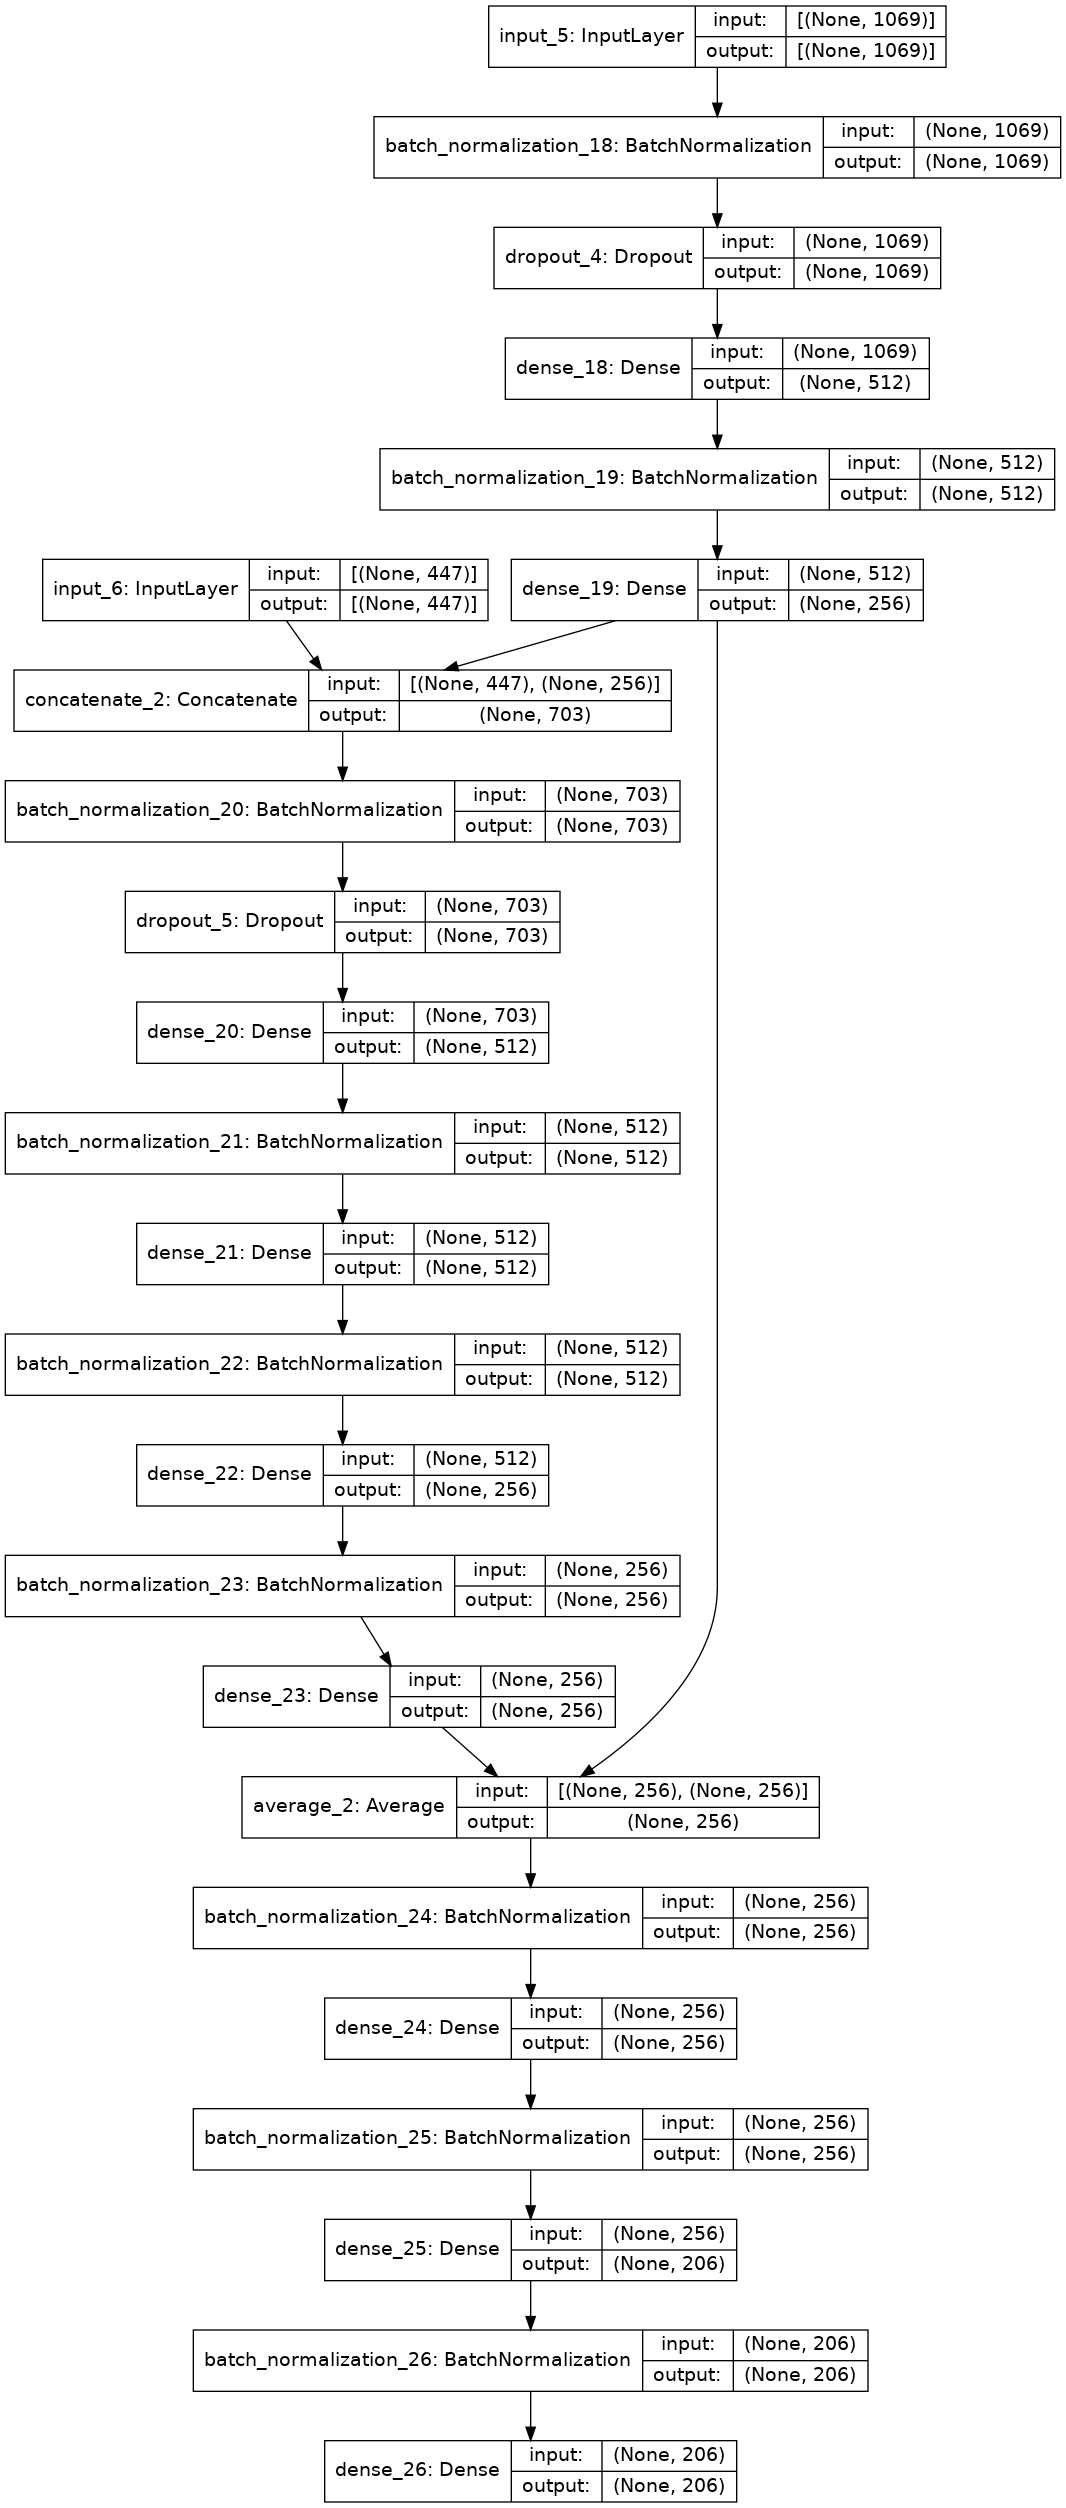

In [217]:
from tensorflow import keras
keras.utils.plot_model(model_resnet,"model_resnet_with_shape_info.png",show_shapes=True)

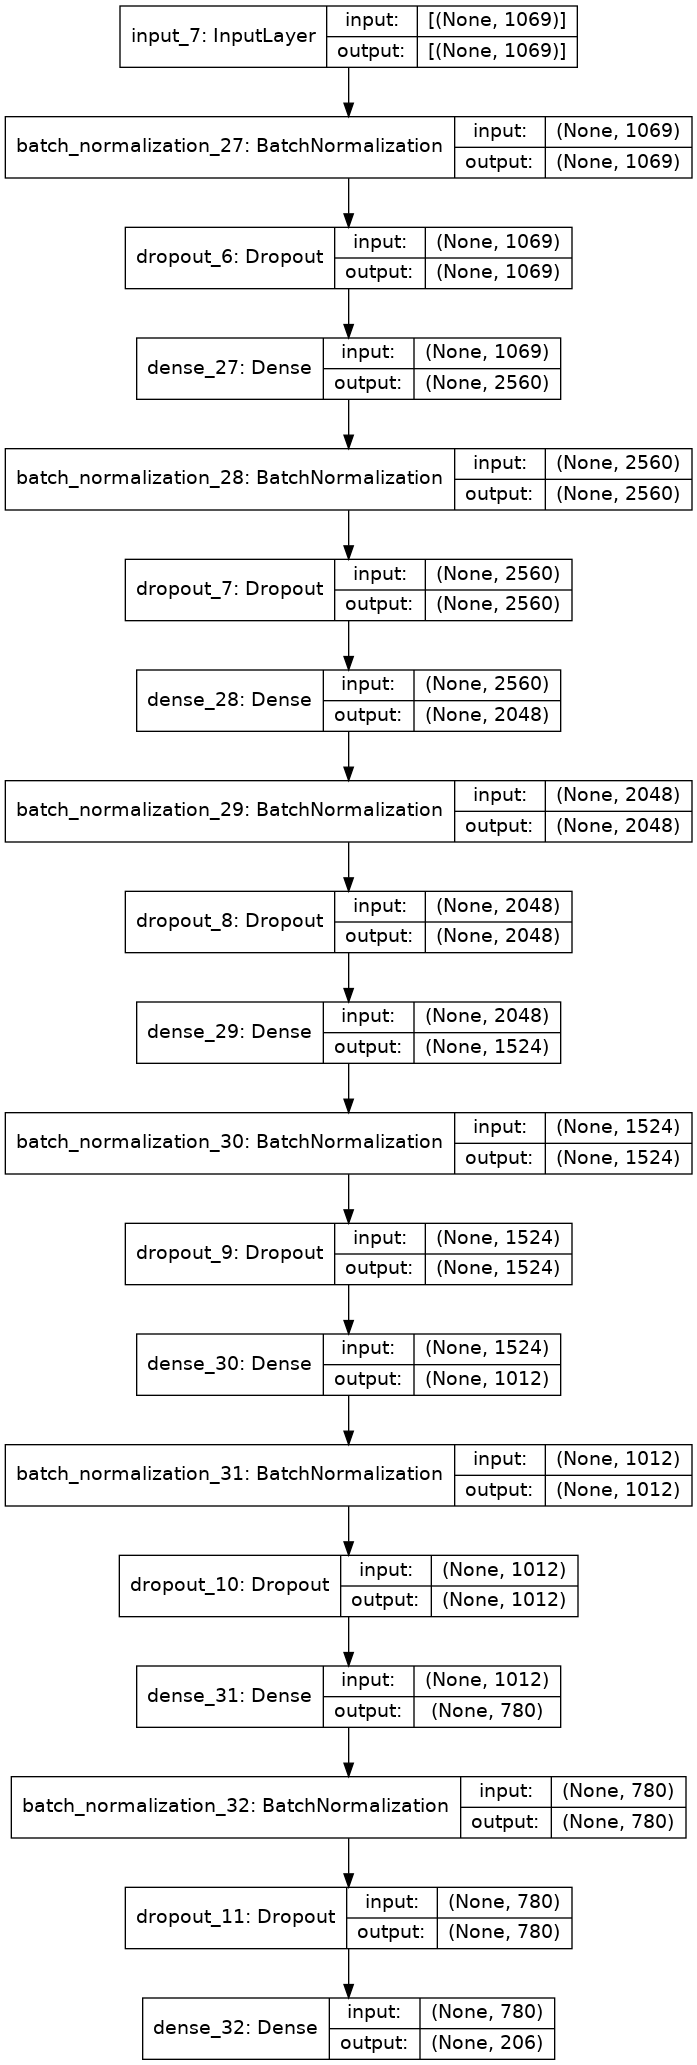

In [215]:
keras.utils.plot_model(model_5layer,"model_5_with_shape_info.png",show_shapes=True)

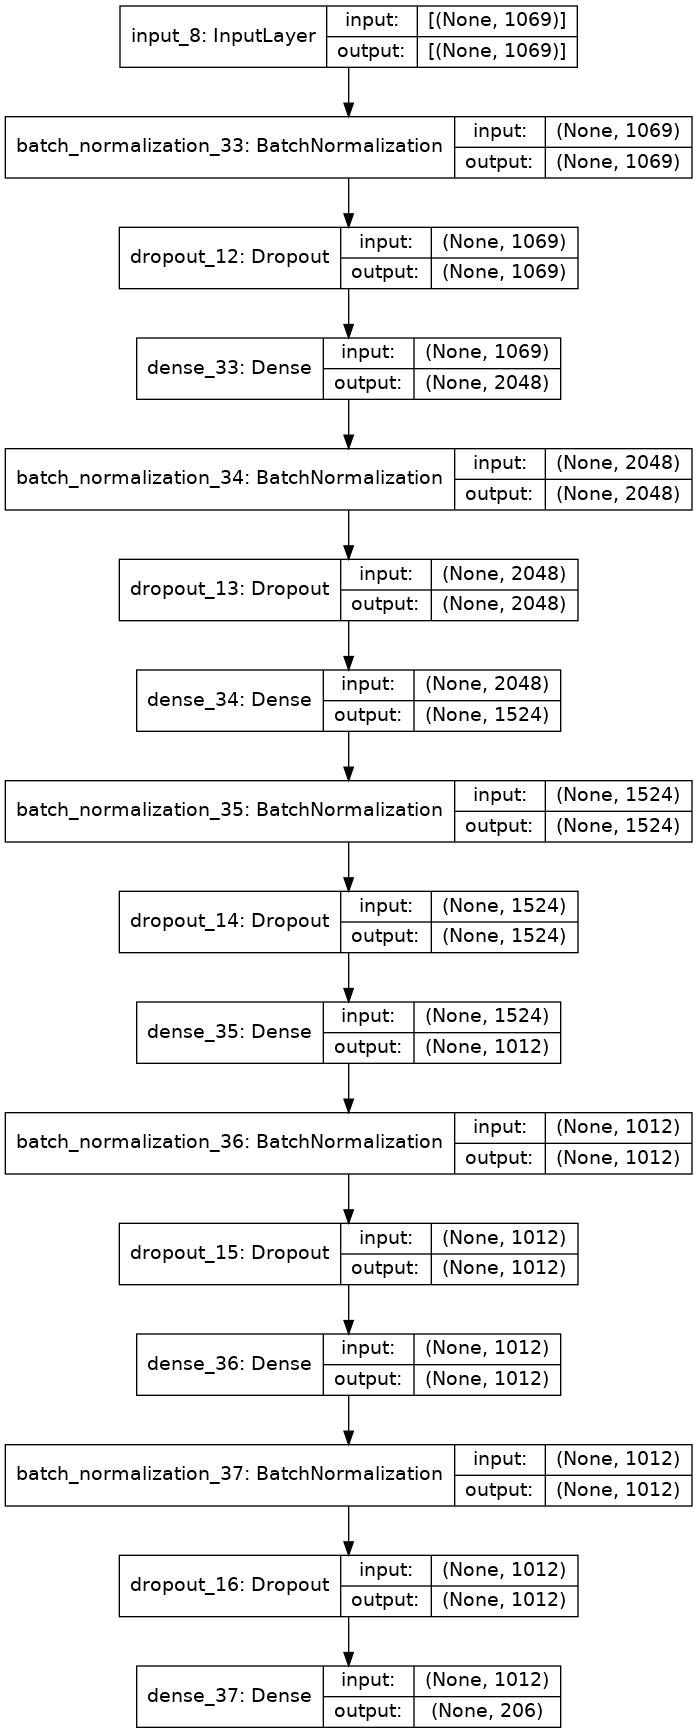

In [218]:
keras.utils.plot_model(model_4layer,"model_4_with_shape_info.png",show_shapes=True)

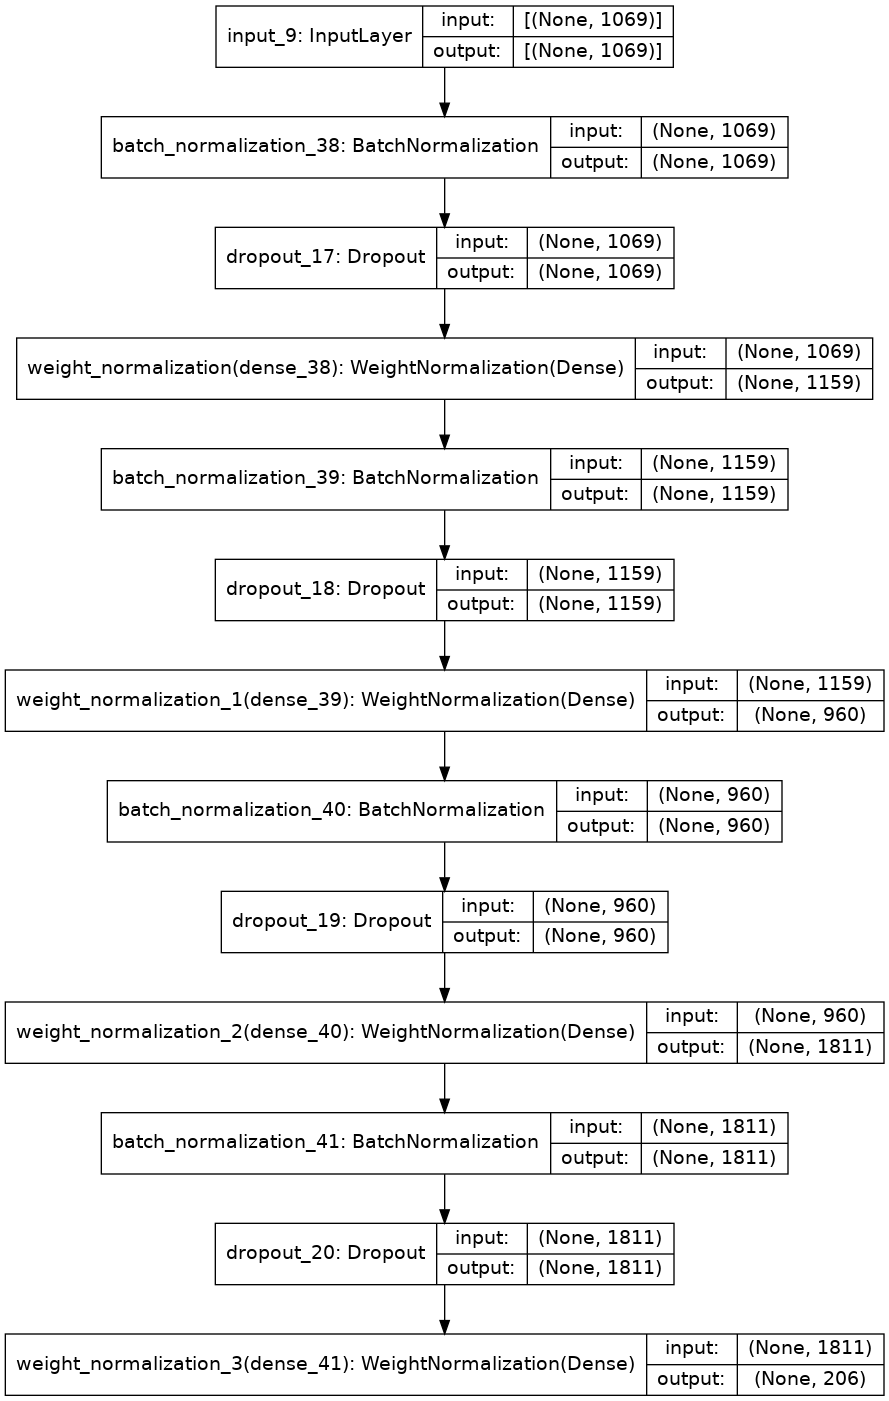

In [219]:
keras.utils.plot_model(model_3layer,"model_3_with_shape_info.png",show_shapes=True)

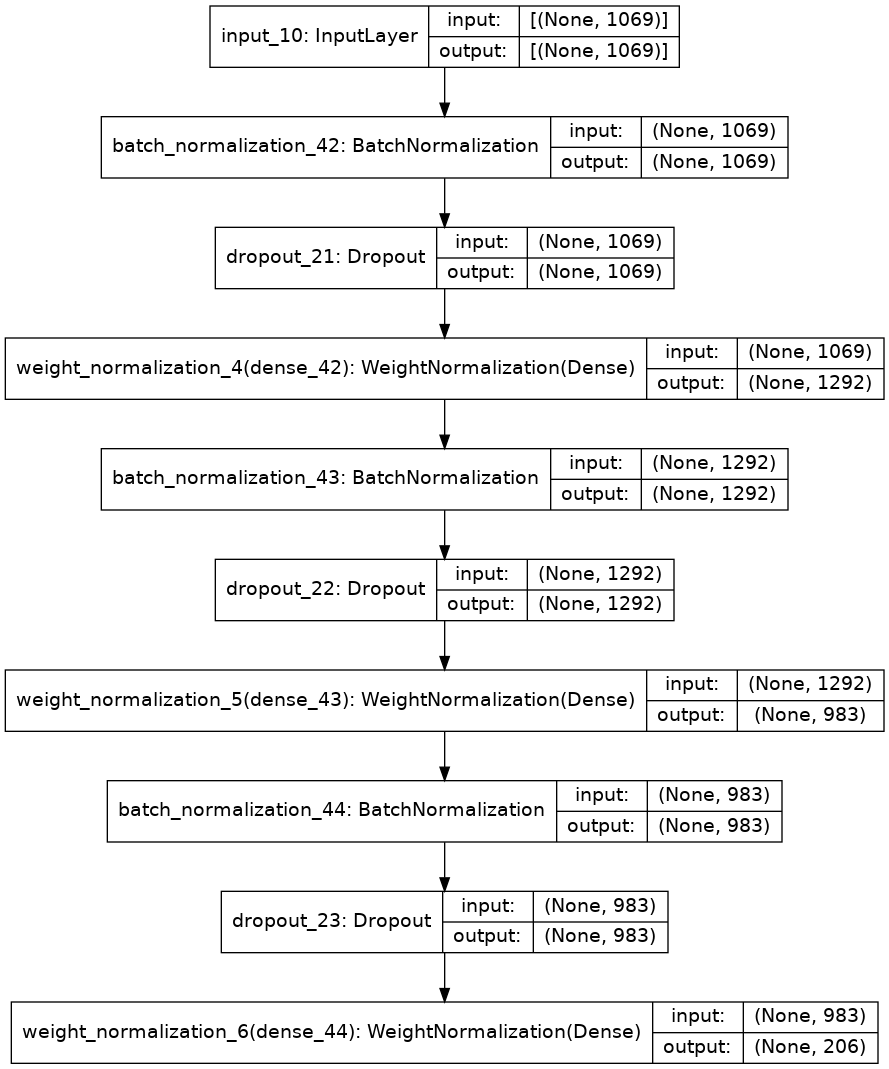

In [220]:
keras.utils.plot_model(model_2layer,"model_2_with_shape_info.png",show_shapes=True)

In [221]:
sub3  = sample_submission

In [222]:
submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [223]:
public_ids = list(submission['sig_id'].values)

submission.shape

(3982, 207)

In [224]:
test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

test_ids = list(test['sig_id'].values)

private_ids = list(set(test_ids)-set(public_ids))

len(private_ids)

0

In [225]:
predictions = [sub3,sub2,sub1]

In [226]:
target_columns = list(submission.columns)
target_columns.remove('sig_id')

In [227]:
y_pred = pd.DataFrame()
y_pred['sig_id'] = predictions[0]['sig_id']

for column in target_columns:
    column_data = []
    for i in range(len(predictions)):
        column_data.append(predictions[i][column])
    y_pred[column] = np.mean(column_data, axis=0)

y_pred.shape

(3982, 207)

In [228]:
#weights = [0.3345993850605896, 0.33387592693072893, 0.3315246880086815]
weights = [0.32, 0.34, 0.34]

In [229]:
weighted_y_pred = pd.DataFrame()
weighted_y_pred['sig_id'] = predictions[0]['sig_id']

for column in target_columns:
    column_data = []
    for i in range(len(predictions)):
        column_data.append(predictions[i][column] * weights[i])
    weighted_y_pred[column] = np.sum(column_data, axis=0)

weighted_y_pred.shape

(3982, 207)

In [230]:
y_pred = weighted_y_pred

In [231]:
submission = pd.DataFrame(index = public_ids + private_ids, columns=target_columns)
submission.index.name = 'sig_id'

submission[:] = 0

submission.loc[y_pred.sig_id,:] = y_pred[target_columns].values

submission.loc[test[test.cp_type == 'ctl_vehicle'].sig_id] = 0

submission.to_csv('submission.csv', index=True)

In [232]:
submission

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_0004d9e33,0.001438,0.001525,0.002063,0.016718,0.022390,0.004898,0.002915,0.005191,0.000518,0.012228,...,0.001211,0.001509,0.003755,0.001326,0.001000,0.000941,0.001283,0.002086,0.004384,0.001776
id_001897cda,0.000686,0.001186,0.001735,0.002483,0.001501,0.002417,0.003435,0.014548,0.015286,0.011827,...,0.001068,0.001687,0.003651,0.001125,0.007741,0.000963,0.008240,0.001475,0.004266,0.003802
id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
id_00276f245,0.000953,0.000994,0.001960,0.010609,0.013733,0.004447,0.002972,0.004570,0.000640,0.019503,...,0.000886,0.001311,0.002763,0.012849,0.005082,0.000789,0.001493,0.002115,0.001590,0.002910
id_0027f1083,0.002489,0.001572,0.002240,0.015471,0.021599,0.004054,0.004836,0.002227,0.000653,0.010046,...,0.001132,0.001002,0.004274,0.002201,0.001454,0.001016,0.001870,0.002193,0.000666,0.001758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_ff7004b87,0.000895,0.001353,0.001582,0.003652,0.005517,0.002819,0.001584,0.003668,0.000817,0.003637,...,0.001005,0.007257,0.002332,0.119883,0.009283,0.001258,0.006390,0.001591,0.001018,0.001543
id_ff925dd0d,0.004409,0.002760,0.001337,0.007893,0.022304,0.005799,0.005073,0.004316,0.001012,0.013828,...,0.000882,0.001135,0.003090,0.001894,0.002144,0.001186,0.002894,0.001916,0.001033,0.001833
id_ffb710450,0.002212,0.001361,0.001408,0.014574,0.054028,0.006074,0.004002,0.003794,0.000483,0.013429,...,0.000812,0.000877,0.002669,0.001530,0.001761,0.000840,0.001196,0.001708,0.000744,0.001516
